# CHAPTER 6 Text Similarity and Clustering


## Text Normalization


In [1]:
from contractions import CONTRACTION_MAP
import re
import nltk
import string
from nltk.stem import WordNetLemmatizer
from HTMLParser import HTMLParser
import unicodedata

stopword_list = nltk.corpus.stopwords.words('english')
stopword_list = stopword_list + ['mr', 'mrs', 'come', 'go', 'get',
                                 'tell', 'listen', 'one', 'two', 'three',
                                 'four', 'five', 'six', 'seven', 'eight',
                                 'nine', 'zero', 'join', 'find', 'make',
                                 'say', 'ask', 'tell', 'see', 'try', 'back',
                                 'also']
wnl = WordNetLemmatizer()
html_parser = HTMLParser()

def tokenize_text(text):
    tokens = nltk.word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

def expand_contractions(text, contraction_mapping):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
    
    
from pattern.en import tag
from nltk.corpus import wordnet as wn

# Annotate text tokens with POS tags
def pos_tag_text(text):
    
    def penn_to_wn_tags(pos_tag):
        if pos_tag.startswith('J'):
            return wn.ADJ
        elif pos_tag.startswith('V'):
            return wn.VERB
        elif pos_tag.startswith('N'):
            return wn.NOUN
        elif pos_tag.startswith('R'):
            return wn.ADV
        else:
            return None
    
    tagged_text = tag(text)
    tagged_lower_text = [(word.lower(), penn_to_wn_tags(pos_tag))
                         for word, pos_tag in
                         tagged_text]
    return tagged_lower_text
    
# lemmatize text based on POS tags    
def lemmatize_text(text):
    
    pos_tagged_text = pos_tag_text(text)
    lemmatized_tokens = [wnl.lemmatize(word, pos_tag) if pos_tag
                         else word                     
                         for word, pos_tag in pos_tagged_text]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text
    

def remove_special_characters(text):
    tokens = tokenize_text(text)
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filtered_tokens = filter(None, [pattern.sub(' ', token) for token in tokens])
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text
    
    
def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def keep_text_characters(text):
    filtered_tokens = []
    tokens = tokenize_text(text)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

def unescape_html(parser, text):
    
    return parser.unescape(text)

def normalize_corpus(corpus, lemmatize=True, 
                     only_text_chars=False,
                     tokenize=False):
    
    normalized_corpus = []    
    for text in corpus:
        text = html_parser.unescape(text)
        text = expand_contractions(text, CONTRACTION_MAP)
        if lemmatize:
            text = lemmatize_text(text)
        else:
            text = text.lower()
        text = remove_special_characters(text)
        text = remove_stopwords(text)
        if only_text_chars:
            text = keep_text_characters(text)
        
        if tokenize:
            text = tokenize_text(text)
            normalized_corpus.append(text)
        else:
            normalized_corpus.append(text)
            
    return normalized_corpus


def parse_document(document):
    document = re.sub('\n', ' ', document)
    if isinstance(document, str):
        document = document
    elif isinstance(document, unicode):
        return unicodedata.normalize('NFKD', document).encode('ascii', 'ignore')
    else:
        raise ValueError('Document is not string or unicode!')
    document = document.strip()
    sentences = nltk.sent_tokenize(document)
    sentences = [sentence.strip() for sentence in sentences]
    return sentences


## Feature Extraction


In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def build_feature_matrix(documents, feature_type='frequency',
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    
    if feature_type == 'binary':
        vectorizer = CountVectorizer(binary=True, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'frequency':
        vectorizer = CountVectorizer(binary=False, min_df=min_df,
                                     max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, 
                                     ngram_range=ngram_range)
    else:
        raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'")

    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

## Analyzing Term Similarity


In [3]:
import numpy as np
from scipy.stats import itemfreq

def vectorize_terms(terms):
    terms = [term.lower() for term in terms]
    terms = [np.array(list(term)) for term in terms]
    terms = [np.array([ord(char) for char in term]) 
                for term in terms]
    return terms
    
def boc_term_vectors(word_list):
    word_list = [word.lower() for word in word_list]
    unique_chars = np.unique(
                        np.hstack([list(word) 
                        for word in word_list]))
    word_list_term_counts = [{char: count for char, count in itemfreq(list(word))}
                             for word in word_list]
    
    boc_vectors = [np.array([int(word_term_counts.get(char, 0)) 
                            for char in unique_chars])
                   for word_term_counts in word_list_term_counts]
    return list(unique_chars), boc_vectors


In [4]:
root = 'Believe'
term1 = 'beleive'
term2 = 'bargain'
term3 = 'Elephant'    

terms = [root, term1, term2, term3]

vec_root, vec_term1, vec_term2, vec_term3 = vectorize_terms(terms)
print '''
root: {}
term1: {}
term2: {}
term3: {}
'''.format(vec_root, vec_term1, vec_term2, vec_term3)



root: [ 98 101 108 105 101 118 101]
term1: [ 98 101 108 101 105 118 101]
term2: [ 98  97 114 103  97 105 110]
term3: [101 108 101 112 104  97 110 116]



In [5]:
features, (boc_root, boc_term1, boc_term2, boc_term3) = boc_term_vectors(terms)
print 'Features:', features
print '''
root: {}
term1: {}
term2: {}
term3: {}
'''.format(boc_root, boc_term1, boc_term2, boc_term3)


Features: ['a', 'b', 'e', 'g', 'h', 'i', 'l', 'n', 'p', 'r', 't', 'v']

root: [0 1 3 0 0 1 1 0 0 0 0 1]
term1: [0 1 3 0 0 1 1 0 0 0 0 1]
term2: [2 1 0 1 0 1 0 1 0 1 0 0]
term3: [1 0 2 0 1 0 1 1 1 0 1 0]



### Hamming Distance


In [6]:
def hamming_distance(u, v, norm=False):
    if u.shape != v.shape:
        raise ValueError('The vectors must have equal lengths.')
    return (u != v).sum() if not norm else (u != v).mean()


In [8]:
# DEMOS!

# build the term vectors here    
root_term = root
root_vector = vec_root
root_boc_vector = boc_root

terms = [term1, term2, term3]
vector_terms = [vec_term1, vec_term2, vec_term3]
boc_vector_terms = [boc_term1, boc_term2, boc_term3]


In [9]:
# HAMMING DISTANCE DEMO
for term, vector_term in zip(terms, vector_terms):
    print 'Hamming distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                hamming_distance(root_vector, vector_term, norm=False))


Hamming distance between root: Believe and term: beleive is 2
Hamming distance between root: Believe and term: bargain is 6


ValueError: The vectors must have equal lengths.

In [14]:
for term, vector_term in zip(terms, vector_terms):
    print 'Normalized Hamming distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(hamming_distance(root_vector, vector_term, norm=True), 2))


Normalized Hamming distance between root: Believe and term: beleive is 0.29
Normalized Hamming distance between root: Believe and term: bargain is 0.86


ValueError: The vectors must have equal lengths.

### Manhattan Distance


In [13]:
def manhattan_distance(u, v, norm=False):
    if u.shape != v.shape:
        raise ValueError('The vectors must have equal lengths.')
    return abs(u - v).sum() if not norm else abs(u - v).mean()



In [15]:
for term, vector_term in zip(terms, vector_terms):
    print 'Manhattan distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                manhattan_distance(root_vector, vector_term, norm=False))


Manhattan distance between root: Believe and term: beleive is 8
Manhattan distance between root: Believe and term: bargain is 38


ValueError: The vectors must have equal lengths.

In [16]:
for term, vector_term in zip(terms, vector_terms):
    print 'Normalized Manhattan distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(manhattan_distance(root_vector, vector_term, norm=True),2))


Normalized Manhattan distance between root: Believe and term: beleive is 1.14
Normalized Manhattan distance between root: Believe and term: bargain is 5.43


ValueError: The vectors must have equal lengths.

### Euclidean Distance


In [17]:
def euclidean_distance(u,v):
    if u.shape != v.shape:
        raise ValueError('The vectors must have equal lengths.')
    distance = np.sqrt(np.sum(np.square(u - v)))
    return distance


In [18]:
for term, vector_term in zip(terms, vector_terms):
    print 'Euclidean distance between root: {} and term: {} is {}'.format(root_term,
                                                                term,
                                                                round(euclidean_distance(root_vector, vector_term),2))



Euclidean distance between root: Believe and term: beleive is 5.66
Euclidean distance between root: Believe and term: bargain is 17.94


ValueError: The vectors must have equal lengths.

### Levenshtein Edit Distance


In [7]:
import copy
import pandas as pd

def levenshtein_edit_distance(u, v):
    # convert to lower case
    u = u.lower()
    v = v.lower()
    # base cases
    if u == v: return 0
    elif len(u) == 0: return len(v)
    elif len(v) == 0: return len(u)
    # initialize edit distance matrix
    edit_matrix = []
    # initialize two distance matrices 
    du = [0] * (len(v) + 1)
    dv = [0] * (len(v) + 1)
    # du: the previous row of edit distances
    for i in range(len(du)):
        du[i] = i
    # dv : the current row of edit distances    
    for i in range(len(u)):
        dv[0] = i + 1
        # compute cost as per algorithm
        for j in range(len(v)):
            cost = 0 if u[i] == v[j] else 1
            dv[j + 1] = min(dv[j] + 1, du[j + 1] + 1, du[j] + cost)
        # assign dv to du for next iteration
        for j in range(len(du)):
            du[j] = dv[j]
        # copy dv to the edit matrix
        edit_matrix.append(copy.copy(dv))
    # compute the final edit distance and edit matrix    
    distance = dv[len(v)]
    edit_matrix = np.array(edit_matrix)
    edit_matrix = edit_matrix.T
    edit_matrix = edit_matrix[1:,]
    edit_matrix = pd.DataFrame(data=edit_matrix,
                               index=list(v),
                               columns=list(u))
    return distance, edit_matrix
    


In [19]:
for term in terms:
    edit_d, edit_m = levenshtein_edit_distance(root_term, term)
    print 'Computing distance between root: {} and term: {}'.format(root_term,
                                                                    term)
    print 'Levenshtein edit distance is {}'.format(edit_d)
    print 'The complete edit distance matrix is depicted below'
    print edit_m
    print '-'*30                                                                             


Computing distance between root: Believe and term: beleive
Levenshtein edit distance is 2
The complete edit distance matrix is depicted below
   b  e  l  i  e  v  e
b  0  1  2  3  4  5  6
e  1  0  1  2  3  4  5
l  2  1  0  1  2  3  4
e  3  2  1  1  1  2  3
i  4  3  2  1  2  2  3
v  5  4  3  2  2  2  3
e  6  5  4  3  2  3  2
------------------------------
Computing distance between root: Believe and term: bargain
Levenshtein edit distance is 6
The complete edit distance matrix is depicted below
   b  e  l  i  e  v  e
b  0  1  2  3  4  5  6
a  1  1  2  3  4  5  6
r  2  2  2  3  4  5  6
g  3  3  3  3  4  5  6
a  4  4  4  4  4  5  6
i  5  5  5  4  5  5  6
n  6  6  6  5  5  6  6
------------------------------
Computing distance between root: Believe and term: Elephant
Levenshtein edit distance is 7
The complete edit distance matrix is depicted below
   b  e  l  i  e  v  e
e  1  1  2  3  4  5  6
l  2  2  1  2  3  4  5
e  3  2  2  2  2  3  4
p  4  3  3  3  3  3  4
h  5  4  4  4  4  4  4
a  6 

### Cosine Distance and Similarity


In [20]:
def cosine_distance(u, v):
    distance = 1.0 - (np.dot(u, v) / 
                        (np.sqrt(sum(np.square(u))) * np.sqrt(sum(np.square(v))))
                     )
    return distance


In [21]:
for term, boc_term in zip(terms, boc_vector_terms):
    print 'Analyzing similarity between root: {} and term: {}'.format(root_term,
                                                                      term)
    distance = round(cosine_distance(root_boc_vector, boc_term),2)
    similarity = 1 - distance                                                           
    print 'Cosine distance  is {}'.format(distance)
    print 'Cosine similarity  is {}'.format(similarity)
    print '-'*40


Analyzing similarity between root: Believe and term: beleive
Cosine distance  is -0.0
Cosine similarity  is 1.0
----------------------------------------
Analyzing similarity between root: Believe and term: bargain
Cosine distance  is 0.82
Cosine similarity  is 0.18
----------------------------------------
Analyzing similarity between root: Believe and term: Elephant
Cosine distance  is 0.39
Cosine similarity  is 0.61
----------------------------------------


## Analyzing Document Similarity


In [22]:
#from normalization import normalize_corpus
#from utils import build_feature_matrix
import numpy as np


In [23]:
toy_corpus = ['The sky is blue',
'The sky is blue and beautiful',
'Look at the bright blue sky!',
'Python is a great Programming language',
'Python and Java are popular Programming languages',
'Among Programming languages, both Python and Java are the most used in Analytics',
'The fox is quicker than the lazy dog',
'The dog is smarter than the fox',
'The dog, fox and cat are good friends']


In [24]:
query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']  



In [25]:
# normalize and extract features from the toy corpus
norm_corpus = normalize_corpus(toy_corpus, lemmatize=True)
tfidf_vectorizer, tfidf_features = build_feature_matrix(norm_corpus,
                                                        feature_type='tfidf',
                                                        ngram_range=(1, 1), 
                                                        min_df=0.0, max_df=1.0)
                                                        


In [26]:
# normalize and extract features from the query corpus
norm_query_docs =  normalize_corpus(query_docs, lemmatize=True)            
query_docs_tfidf = tfidf_vectorizer.transform(norm_query_docs)


### Cosine Similarity


In [31]:
def compute_cosine_similarity(doc_features, corpus_features,
                              top_n=3):
    # get document vectors
    doc_features = doc_features[0]
    # compute similarities
    #similarity = np.dot(doc_features, corpus_features.T)
    similarity = doc_features * corpus_features.T
    similarity = similarity.toarray()[0]
    # get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    return top_docs_with_score


In [32]:
print 'Document Similarity Analysis using Cosine Similarity'
print '='*60
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf,
                                             tfidf_features,
                                             top_n=2)
    print 'Document',index+1 ,':', doc
    print 'Top', len(top_similar_docs), 'similar docs:'
    print '-'*40 
    for doc_index, sim_score in top_similar_docs:
        print 'Doc num: {} Similarity Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index])  
        print '-'*40       
    print                                                      


Document Similarity Analysis using Cosine Similarity
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 8 Similarity Score: 1.0
Doc: The dog is smarter than the fox
----------------------------------------
Doc num: 7 Similarity Score: 0.426
Doc: The fox is quicker than the lazy dog
----------------------------------------

Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 5 Similarity Score: 0.837
Doc: Python and Java are popular Programming languages
----------------------------------------
Doc num: 6 Similarity Score: 0.661
Doc: Among Programming languages, both Python and Java are the most used in Analytics
----------------------------------------

Document 3 : I love to relax under the beautiful blue sky!
Top 2 similar docs:
----------------------------------------
Doc num: 2 Similarity Score: 1.0
Doc: The sky is blue 

### Hellinger-Bhattacharya Distance


In [33]:
def compute_hellinger_bhattacharya_distance(doc_features, corpus_features,
                                            top_n=3):
    # get document vectors                                            
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute hb distances
    distance = np.hstack(
                    np.sqrt(0.5 *
                            np.sum(
                                np.square(np.sqrt(doc_features) - 
                                          np.sqrt(corpus_features)), 
                                axis=1)))
    # get docs with lowest distance scores                            
    top_docs = distance.argsort()[:top_n]
    top_docs_with_score = [(index, round(distance[index], 3))
                            for index in top_docs]
    return top_docs_with_score 


In [34]:
print 'Document Similarity Analysis using Hellinger-Bhattacharya distance'
print '='*60
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_hellinger_bhattacharya_distance(doc_tfidf,
                                             tfidf_features,
                                             top_n=2)
    print 'Document',index+1 ,':', doc
    print 'Top', len(top_similar_docs), 'similar docs:'
    print '-'*40 
    for doc_index, sim_score in top_similar_docs:
        print 'Doc num: {} Distance Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index])  
        print '-'*40       
    print                 


Document Similarity Analysis using Hellinger-Bhattacharya distance
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 8 Distance Score: 0.0
Doc: The dog is smarter than the fox
----------------------------------------
Doc num: 7 Distance Score: 0.96
Doc: The fox is quicker than the lazy dog
----------------------------------------

Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 5 Distance Score: 0.53
Doc: Python and Java are popular Programming languages
----------------------------------------
Doc num: 4 Distance Score: 0.766
Doc: Python is a great Programming language
----------------------------------------

Document 3 : I love to relax under the beautiful blue sky!
Top 2 similar docs:
----------------------------------------
Doc num: 2 Distance Score: 0.0
Doc: The sky is blue and beautiful
--------------------------

### Okapi BM25 Ranking


In [35]:
import scipy.sparse as sp 

def compute_corpus_term_idfs(corpus_features, norm_corpus):
    
    dfs = np.diff(sp.csc_matrix(corpus_features, copy=True).indptr)
    dfs = 1 + dfs # to smoothen idf later
    total_docs = 1 + len(norm_corpus)
    idfs = 1.0 + np.log(float(total_docs) / dfs)
    return idfs



In [36]:
def compute_bm25_similarity(doc_features, corpus_features,
                            corpus_doc_lengths, avg_doc_length,
                            term_idfs, k1=1.5, b=0.75, top_n=3):
    # get corpus bag of words features
    corpus_features = corpus_features.toarray()
    # convert query document features to binary features
    # this is to keep a note of which terms exist per document
    doc_features = doc_features.toarray()[0]
    doc_features[doc_features >= 1] = 1
    
    # compute the document idf scores for present terms
    doc_idfs = doc_features * term_idfs
    # compute numerator expression in BM25 equation
    numerator_coeff = corpus_features * (k1 + 1)
    numerator = np.multiply(doc_idfs, numerator_coeff)
    # compute denominator expression in BM25 equation
    denominator_coeff =  k1 * (1 - b + 
                                (b * (corpus_doc_lengths / 
                                        avg_doc_length)))
    denominator_coeff = np.vstack(denominator_coeff)
    denominator = corpus_features + denominator_coeff
    # compute the BM25 score combining the above equations
    bm25_scores = np.sum(np.divide(numerator,
                                   denominator),
                         axis=1)
    # get top n relevant docs with highest BM25 score                     
    top_docs = bm25_scores.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(bm25_scores[index], 3))
                            for index in top_docs]
    return top_docs_with_score


In [37]:
vectorizer, corpus_features = build_feature_matrix(norm_corpus,
                                                   feature_type='frequency')
query_docs_features = vectorizer.transform(norm_query_docs)

doc_lengths = [len(doc.split()) for doc in norm_corpus]   
avg_dl = np.average(doc_lengths) 
corpus_term_idfs = compute_corpus_term_idfs(corpus_features,
                                            norm_corpus)


In [38]:
print 'Document Similarity Analysis using BM25'
print '='*60
for index, doc in enumerate(query_docs):
    
    doc_features = query_docs_features[index]
    top_similar_docs = compute_bm25_similarity(doc_features,
                                               corpus_features,
                                               doc_lengths,
                                               avg_dl,
                                               corpus_term_idfs,
                                               k1=1.5, b=0.75,
                                               top_n=2)
    print 'Document',index+1 ,':', doc
    print 'Top', len(top_similar_docs), 'similar docs:'
    print '-'*40 
    for doc_index, sim_score in top_similar_docs:
        print 'Doc num: {} BM25 Score: {}\nDoc: {}'.format(doc_index+1,
                                                                 sim_score,
                                                                 toy_corpus[doc_index])  
        print '-'*40       
    print

Document Similarity Analysis using BM25
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 8 BM25 Score: 7.334
Doc: The dog is smarter than the fox
----------------------------------------
Doc num: 7 BM25 Score: 3.88
Doc: The fox is quicker than the lazy dog
----------------------------------------

Document 2 : Java is a static typed programming language unlike Python
Top 2 similar docs:
----------------------------------------
Doc num: 5 BM25 Score: 7.248
Doc: Python and Java are popular Programming languages
----------------------------------------
Doc num: 6 BM25 Score: 6.042
Doc: Among Programming languages, both Python and Java are the most used in Analytics
----------------------------------------

Document 3 : I love to relax under the beautiful blue sky!
Top 2 similar docs:
----------------------------------------
Doc num: 2 BM25 Score: 7.334
Doc: The sky is blue and beautiful
--------------------------

## Document Clustering


## Clustering Greatest Movies of All Time


In [39]:
import pandas as pd
import numpy as np

movie_data = pd.read_csv('movie_data.csv')

print movie_data.head()


                      Title                                           Synopsis
0             The Godfather  In late summer 1945, guests are gathered for t...
1  The Shawshank Redemption  In 1947, Andy Dufresne (Tim Robbins), a banker...
2          Schindler's List  The relocation of Polish Jews from surrounding...
3               Raging Bull  The film opens in 1964, where an older and fat...
4                Casablanca  In the early years of World War II, December 1...


In [40]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

print 'Movie:', movie_titles[0]
print 'Movie Synopsis:', movie_synopses[0][:1000]


Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. T

In [41]:
#from normalization import normalize_corpus
#from utils import build_feature_matrix

# normalize corpus
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))
# view number of features
print feature_matrix.shape     


(100, 307)


In [42]:
# get feature names
feature_names = vectorizer.get_feature_names()

# print sample features
print feature_names[:20]      


[u'able', u'accept', u'across', u'act', u'agree', u'alive', u'allow', u'alone', u'along', u'already', u'although', u'always', u'another', u'anything', u'apartment', u'appear', u'approach', u'arm', u'army', u'around']


### K-means Clustering


In [43]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters


In [44]:
num_clusters = 5    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters


from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print c.items()


[(0, 46), (1, 12), (2, 19), (3, 17), (4, 6)]


In [45]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details
        
       
    
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print 'Cluster {} details:'.format(cluster_num)
        print '-'*20
        print 'Key features:', cluster_details['key_features']
        print 'Movies in this cluster:'
        print ', '.join(cluster_details['movies'])
        print '='*40


In [46]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties


In [47]:
def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 


Cluster 0 details:
--------------------
Key features: [u'police', u'apartment', u'man', u'car', u'woman']
Movies in this cluster:
The Shawshank Redemption, Schindler's List, Casablanca, One Flew Over the Cuckoo's Nest, The Wizard of Oz, Psycho, Sunset Blvd., Vertigo, On the Waterfront, West Side Story, Star Wars, E.T. the Extra-Terrestrial, 2001: A Space Odyssey, The Silence of the Lambs, It's a Wonderful Life, Some Like It Hot, 12 Angry Men, Gandhi, Unforgiven, Rocky, A Streetcar Named Desire, To Kill a Mockingbird, The Best Years of Our Lives, My Fair Lady, Ben-Hur, The Treasure of the Sierra Madre, The Apartment, High Noon, The Pianist, The French Connection, A Place in the Sun, Midnight Cowboy, Mr. Smith Goes to Washington, Annie Hall, Good Will Hunting, Tootsie, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Double Indemnity, Rebel Without a Cause, Rear Window, The Third Man, North by Northwest
Cluster 1 details:
--------------------
Key features: [u'fam

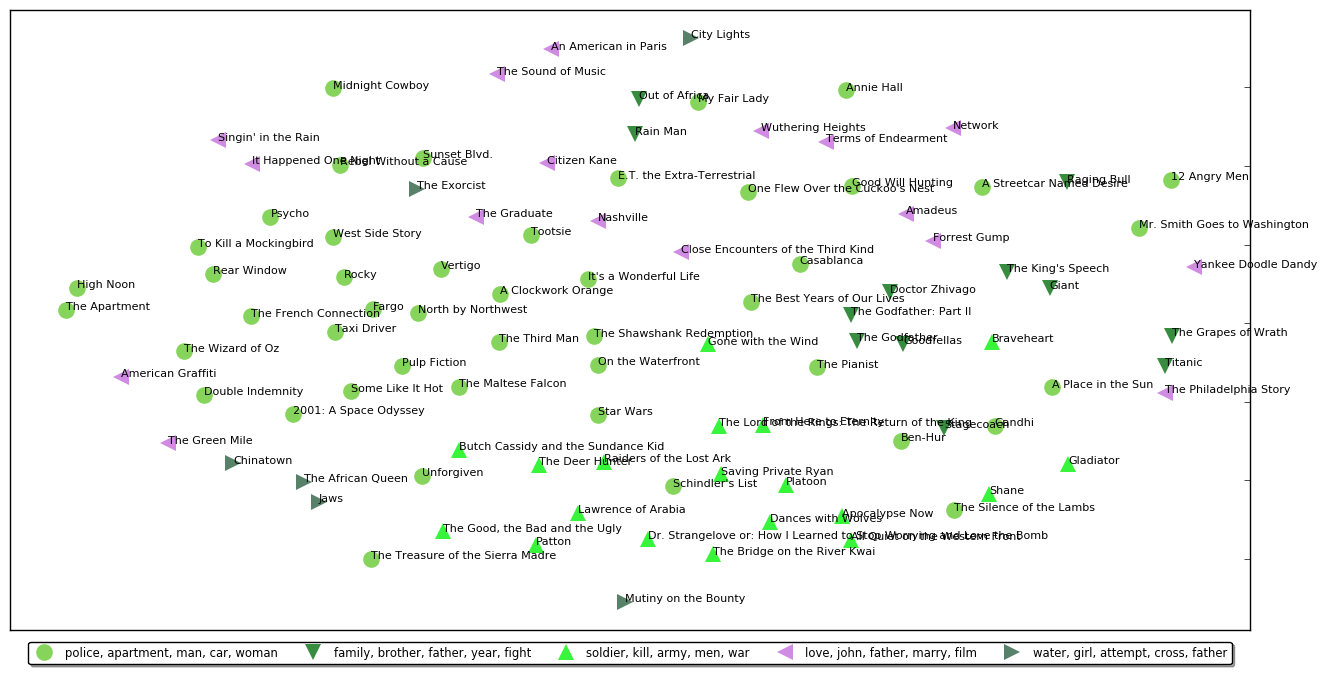

In [48]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))       


### Affinity Propagation


In [49]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters


In [50]:
# get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

# get the total number of movies per cluster
c = Counter(clusters)   
print c.items()  

# get total clusters
total_clusters = len(c)
print 'Total Clusters:', total_clusters


[(0, 5), (1, 6), (2, 12), (3, 6), (4, 2), (5, 7), (6, 10), (7, 7), (8, 4), (9, 8), (10, 3), (11, 4), (12, 5), (13, 7), (14, 4), (15, 3), (16, 7)]
Total Clusters: 17


In [51]:
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 


Cluster 0 details:
--------------------
Key features: [u'able', u'always', u'cover', u'end', u'charge']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: [u'alive', u'accept', u'around', u'agree', u'attack']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: [u'apartment', u'film', u'final', u'fall', u'due']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: [u'arrest', u'film', u'evening', u'final', u'fall']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, Close Encounters of the Third K

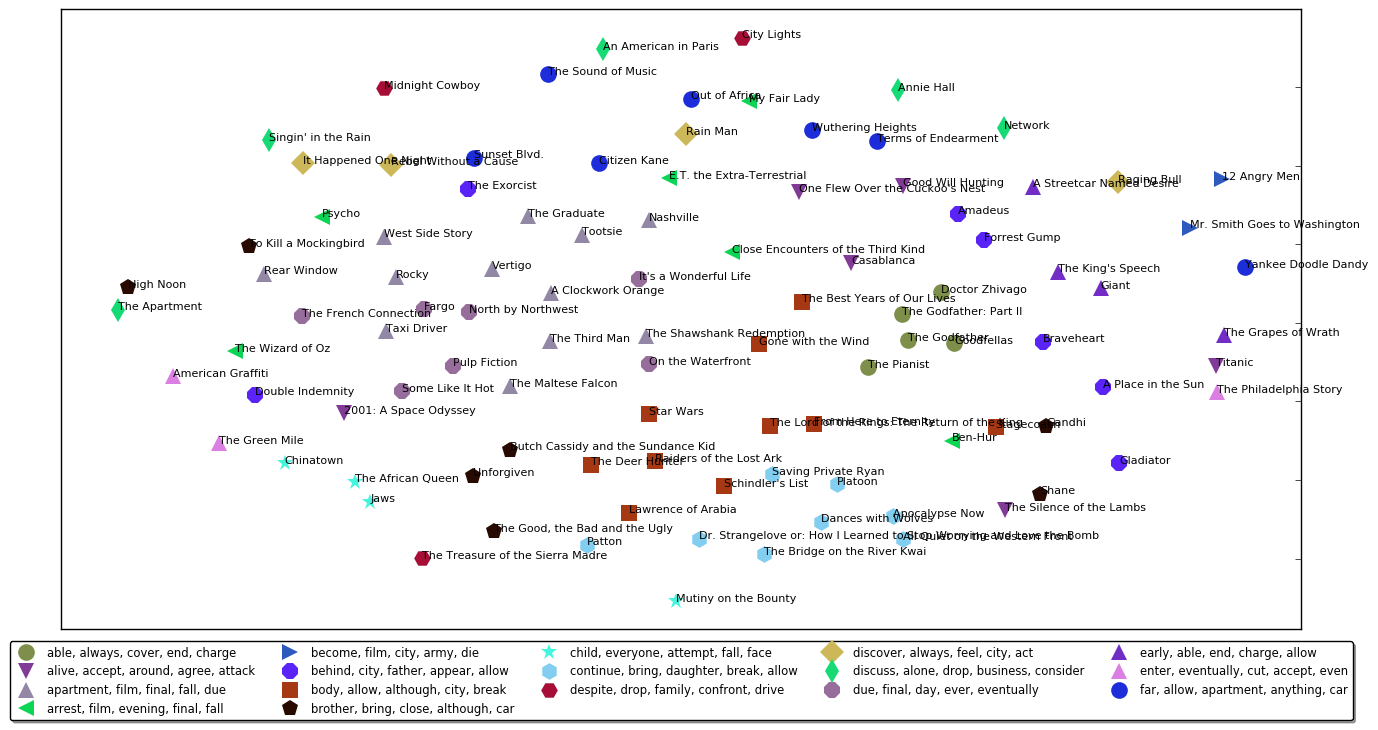

In [52]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 


### Ward’s Agglomerative Hierarchical Clustering


In [55]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    #plt.savefig('ward_hierachical_clusters.png', dpi=200)
    plt.show()


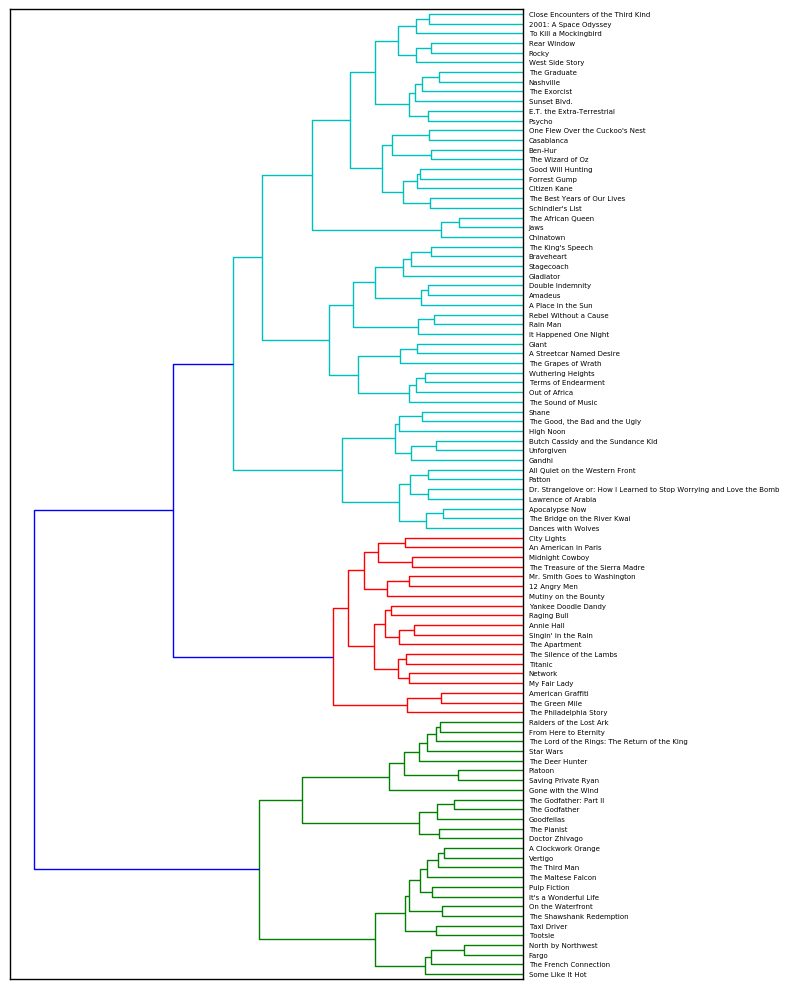

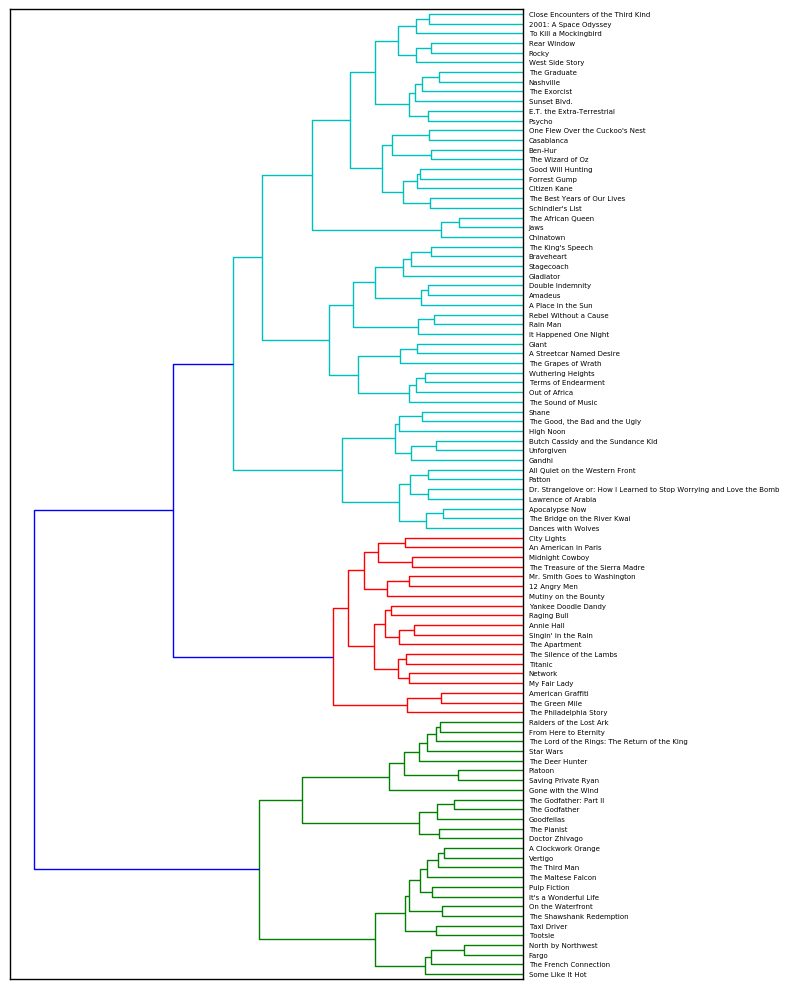

In [56]:
# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))